In [11]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import os
from model_utils import *
import scipy.stats as stats 

## Model Deep Dive: CSOP

Using the CSOP Dataset, build a model that progressively accounts for different aspects of the data...

Team Composition:
- skill
- social_perceptivness
- cogStyleDiversity
- cogStyleSpeed

Task Features:
- complexity

Conversation Features (All)

In [12]:
# PARAMETERS
min_num_chats = 0
desired_target = "normalized_score"
data_path = "../output/"
output_path = "./results/csop/" + "min=" + str(min_num_chats) + "/" + desired_target + "/"
validation_results_output_name = output_path + "csop_lasso_ridge_experiments" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats) + ".csv"
test_results_output_name = output_path + "csop_lasso_ridge_experiments" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats) + "_CSOPII_out_of_sample_test" + ".csv"

In [13]:
def read_and_preprocess_data(path, min_num_chats):
    csop_conv_data  = pd.read_csv(path)

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    csop_conv_data = csop_conv_data[csop_conv_data["sum_num_messages"] >= min_num_chats]

    # Save the important information

    # Task and Composition features
    task_features = pd.get_dummies(csop_conv_data["complexity"])
    team_composition_features = csop_conv_data[["skill", "social_perceptiveness", "cogStyleDiversity", "skill_diversity"]]

    # possible targets to try
    targets = csop_conv_data[["efficiency","score","normalized_score","duration"]]

    # Read in the config file and use that the drop the extraneous columns
    with open('./config.json', "rb") as json_file:
        config = json.load(json_file)

    conv_features = csop_conv_data.drop(config["csop"]['cols_to_ignore'], axis = 1)

    # Normalization
    team_composition_features = pd.DataFrame(StandardScaler().fit_transform(team_composition_features), columns = team_composition_features.columns)
    conv_features = pd.DataFrame(StandardScaler().fit_transform(conv_features), columns = conv_features.columns)
    # drop na cols
    conv_features = conv_features.dropna(axis = 1)

    targets = pd.DataFrame(StandardScaler().fit_transform(targets), columns = targets.columns)

    return team_composition_features, task_features, conv_features, targets

In [14]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + 'conv/csop_output_conversation_level.csv', min_num_chats=min_num_chats)

In [15]:
# Number of points in dataset
len(conv_features)

93

## Train-Test Split

In [716]:
X = pd.concat([task_features.reset_index(drop=True), team_composition_features.reset_index(drop=True), conv_features.reset_index(drop=True)], axis=1)

In [717]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, random_state=42, test_size=0.2)

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



In [718]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [719]:
def fit_regularized_linear_model(y_target, feature_columns_list, lasso=True, tune_alpha=False):

    if not tune_alpha:
        alpha = 1.0
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    # Calculation of Q^2 metric
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # Initialize a list to store coefficients
    coefficients_list = []

    # Leave one out -- iterate through the entire length of the dataset
    for i in range(len(y_train)):
        # Store the evaluation datapoint
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        # Drop the ith datapoint (leave this one out)
        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        coefficients_list.append(model.coef_)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients


In [720]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return summary_df

In [721]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

In [722]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "q_squared": []
}

result_df = pd.DataFrame(result)

## Team composition features

In [723]:
model_ridge_composition, mrc_q2, mrc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_composition], "model_type": ["Ridge"], "features_included": ["Team Composition"], "alpha": [model_ridge_composition.alpha.round(4)], "q_squared": [mrc_q2]})], ignore_index=True)

Q^2: 0.0766263320310383


In [724]:
directory = os.path.dirname(output_path + 'mrc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrc_feature_coefficients.to_csv(output_path + 'mrc_feature_coefficients' + '.csv')

In [725]:
sort_by_mean_abs(display_feature_coefficients(mrc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
0,skill,0.292090,0.291941,0.292239
3,skill_diversity,0.105744,0.105594,0.105894
1,social_perceptiveness,0.096048,0.095957,0.096138
2,cogStyleDiversity,-0.026793,-0.026874,-0.026711


In [726]:
model_lasso_composition, mlc_q2, mlc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_composition], "model_type": ["Lasso"], "features_included": ["Team Composition"], "alpha": [model_lasso_composition.alpha.round(4)], "q_squared": [mlc_q2]})], ignore_index=True)

Q^2: 0.07662863489082916


In [727]:
directory = os.path.dirname(output_path + 'mlc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlc_feature_coefficients.to_csv(output_path + 'mlc_feature_coefficients' + '.csv')

## Task Features

In [728]:
model_ridge_task, mrt_q2, mrt_feature_coefficients = fit_regularized_linear_model(desired_target, task_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_task], "model_type": ["Ridge"], "features_included": ["Task Complexity"], "alpha": [model_ridge_task.alpha.round(4)], "q_squared": [mrt_q2]})], ignore_index=True)

Q^2: 0.12019681111356617


In [729]:
directory = os.path.dirname(output_path + 'mrt_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrt_feature_coefficients.to_csv(output_path + 'mrt_feature_coefficients' + '.csv')

In [730]:
sort_by_mean_abs(display_feature_coefficients(mrt_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.417923,0.417804,0.418041
3,Very high,-0.389914,-0.390068,-0.389760
1,Low,0.327687,0.327576,0.327799
0,High,-0.196931,-0.197112,-0.196750
2,Moderate,-0.158765,-0.158915,-0.158615


In [731]:
model_lasso_task, mlt_q2, mlt_feature_coefficients = fit_regularized_linear_model(desired_target, task_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_task], "model_type": ["Lasso"], "features_included": ["Task Complexity"], "alpha": [model_lasso_task.alpha.round(4)], "q_squared": [mlt_q2]})], ignore_index=True)

Q^2: 0.12005589172169207


In [732]:
directory = os.path.dirname(output_path + 'mlt_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlt_feature_coefficients.to_csv(output_path + 'mlt_feature_coefficients' + '.csv')

In [733]:
sort_by_mean_abs(display_feature_coefficients(mlt_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.542528,0.542309,0.542747
1,Low,0.452055,0.451843,0.452268
3,Very high,-0.196099,-0.196352,-0.195846
0,High,-0.006017,-0.006228,-0.005806
2,Moderate,0.000000,0.000000,0.000000


## Task + Composition Together

In [734]:
task_comp_features = list(task_features.columns) + list(team_composition_features.columns)

model_ridge_taskcomp, mrtc_q2, mrtc_feature_coefficients = fit_regularized_linear_model(desired_target, task_comp_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_taskcomp], "model_type": ["Ridge"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_ridge_taskcomp.alpha.round(4)], "q_squared": [mrtc_q2]})], ignore_index=True)

Q^2: 0.20290020076779658


In [735]:
directory = os.path.dirname(output_path + 'mrtc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrtc_feature_coefficients.to_csv(output_path + 'mrtc_feature_coefficients' + '.csv')

In [736]:
sort_by_mean_abs(display_feature_coefficients(mrtc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.436747,0.436634,0.436861
3,Very high,-0.402806,-0.402953,-0.402659
1,Low,0.314841,0.314735,0.314946
5,skill,0.305951,0.305811,0.306092
0,High,-0.182775,-0.182946,-0.182604
2,Moderate,-0.166007,-0.166149,-0.165866
8,skill_diversity,0.116663,0.116522,0.116805
6,social_perceptiveness,0.095052,0.094968,0.095136
7,cogStyleDiversity,-0.026386,-0.026462,-0.026310


In [737]:
model_lasso_taskcomp, mltc_q2, mltc_feature_coefficients = fit_regularized_linear_model(desired_target, task_comp_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_taskcomp], "model_type": ["Lasso"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_lasso_taskcomp.alpha.round(4)], "q_squared": [mltc_q2]})], ignore_index=True)

Q^2: 0.2043578800347251


In [738]:
directory = os.path.dirname(output_path + 'mltc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mltc_feature_coefficients.to_csv(output_path + 'mltc_feature_coefficients' + '.csv')

In [739]:
sort_by_mean_abs(display_feature_coefficients(mltc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.570240,0.570056,0.570423
1,Low,0.447925,0.447750,0.448100
5,skill,0.279048,0.278909,0.279187
3,Very high,-0.212015,-0.212234,-0.211795
6,social_perceptiveness,0.091291,0.091206,0.091376
8,skill_diversity,0.089251,0.089110,0.089392
7,cogStyleDiversity,-0.022672,-0.022748,-0.022596
0,High,-0.000057,-0.000100,-0.000014
2,Moderate,-0.000008,-0.000023,0.000008


## Conversation Alone

In [740]:
model_lasso_comms, mlcom_q2, mlcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_comms], "model_type": ["Lasso"], "features_included": ["Communication"], "alpha": [model_lasso_comms.alpha.round(4)], "q_squared": [mlcom_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.211e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.347e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.867e-02, tolerance: 4.791e-02
Objective did n

Q^2: 0.006365854054746878


In [741]:
directory = os.path.dirname(output_path + 'mlcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlcom_feature_coefficients.to_csv(output_path + 'mlcom_feature_coefficients' + '.csv')

In [742]:
sort_by_mean_abs(display_feature_coefficients(mlcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
469,stdev_user_sum_insight,0.058437,0.058252,0.058623
134,stdev_sadness,-0.042899,-0.043042,-0.042757
745,stdev_user_avg_discrepancies,-0.037059,-0.037185,-0.036933
1079,max_user_avg_hasnegative,-0.031990,-0.032166,-0.031814
45,average_achievement,0.026171,0.026052,0.026290
...,...,...,...,...
376,average_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000
377,stdev_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000
378,min_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000
379,max_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000


In [743]:
model_ridge_comms, mrcom_q2, mrcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_comms], "model_type": ["Ridge"], "features_included": ["Communication"], "alpha": [model_ridge_comms.alpha.round(4)], "q_squared": [mrcom_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.211e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.347e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.867e-02, tolerance: 4.791e-02
Objective did n

Q^2: -8.482850705366578


In [744]:
directory = os.path.dirname(output_path + 'mrcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrcom_feature_coefficients.to_csv(output_path + 'mrcom_feature_coefficients' + '.csv')

In [745]:
sort_by_mean_abs(display_feature_coefficients(mrcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
109,average_present_tense,0.612164,0.608172,0.616156
179,min_exclusive,-0.579877,-0.584101,-0.575652
241,average_NTRI,-0.549660,-0.552811,-0.546509
836,average_user_avg_present_tense,0.537526,0.533935,0.541117
33,average_certainty,0.536618,0.534295,0.538942
...,...,...,...,...
43,min_bio,0.000000,0.000000,0.000000
610,min_user_sum_NTRI,0.000000,0.000000,0.000000
88,max_family,0.000000,0.000000,0.000000
335,min_indirect_greeting,0.000000,0.000000,0.000000


## Conversation Features + Task Features

In [746]:
convtask_features = list(task_features.columns) + list(conv_features.columns)
model_lasso_tconv, mltconv_q2, mltconv_feature_coefficients = fit_regularized_linear_model(desired_target, convtask_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_tconv], "model_type": ["Lasso"], "features_included": ["Task Complexity + Communication"], "alpha": [model_lasso_tconv.alpha.round(4)], "q_squared": [mltconv_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.819e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.042e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.110e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.143e-02, tolerance: 4.791e-02
Objective did n

Q^2: 0.08161302690258954


In [747]:
directory = os.path.dirname(output_path + 'mltconv_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mltconv_feature_coefficients.to_csv(output_path + 'mltconv_feature_coefficients' + '.csv')

In [748]:
sort_by_mean_abs(display_feature_coefficients(mltconv_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.268791,0.268612,0.268969
1,Low,0.201259,0.201064,0.201454
3,Very high,-0.084767,-0.084997,-0.084538
474,stdev_user_sum_insight,0.066283,0.066065,0.066501
750,stdev_user_avg_discrepancies,-0.054362,-0.054505,-0.054220
...,...,...,...,...
389,average_user_sum_discrepancies,0.000000,0.000000,0.000000
390,stdev_user_sum_discrepancies,0.000000,0.000000,0.000000
391,min_user_sum_discrepancies,0.000000,0.000000,0.000000
392,max_user_sum_discrepancies,0.000000,0.000000,0.000000


In [749]:
model_ridge_tconv, mrtconv_q2, mrtconv_feature_coefficients = fit_regularized_linear_model(desired_target, convtask_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_tconv], "model_type": ["Ridge"], "features_included": ["Task Complexity + Communication"], "alpha": [model_ridge_tconv.alpha.round(4)], "q_squared": [mrtconv_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.819e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.042e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.110e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.143e-02, tolerance: 4.791e-02
Objective did n

Q^2: -11.110657416854755


In [750]:
directory = os.path.dirname(output_path + 'mrtconv_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrtconv_feature_coefficients.to_csv(output_path + 'mrtconv_feature_coefficients' + '.csv')

In [751]:
sort_by_mean_abs(display_feature_coefficients(mrtconv_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
114,average_present_tense,0.839485,0.834916,0.844054
208,min_cognitive_mech,0.812368,0.808467,0.816270
841,average_user_avg_present_tense,0.700861,0.696802,0.704920
184,min_exclusive,-0.640900,-0.644980,-0.636820
999,min_user_avg_textblob_subjectivity,0.628295,0.626899,0.629692
...,...,...,...,...
731,min_user_sum_indicative,0.000000,0.000000,0.000000
72,min_swear,0.000000,0.000000,0.000000
728,max_user_sum_subjunctive,0.000000,0.000000,0.000000
727,min_user_sum_subjunctive,0.000000,0.000000,0.000000


## Model with All Features

In [752]:
all_features = list(task_features.columns) + list(team_composition_features.columns) + list(conv_features.columns)
model_lasso_all, mlall_q2, mlall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_all], "model_type": ["Lasso"], "features_included": ["All Features"], "alpha": [model_lasso_all.alpha.round(4)], "q_squared": [mlall_q2]})], ignore_index=True)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.193e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.460e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.454e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.013e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.017e-02, tolerance: 4.791e-02
Objective did n

Q^2: 0.1494502410966887


In [753]:
directory = os.path.dirname(output_path + 'mlall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlall_feature_coefficients.to_csv(output_path + 'mlall_feature_coefficients' + '.csv')

In [754]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.319388,0.319219,0.319557
1,Low,0.231430,0.231238,0.231623
5,skill,0.183718,0.183645,0.183790
3,Very high,-0.115182,-0.115399,-0.114966
1086,stdev_user_avg_hasnegative,-0.069382,-0.069588,-0.069176
...,...,...,...,...
391,min_user_sum_info_exchange_zscore_conversation,0.000000,0.000000,0.000000
392,max_user_sum_info_exchange_zscore_conversation,0.000000,0.000000,0.000000
393,average_user_sum_discrepancies,0.000000,0.000000,0.000000
394,stdev_user_sum_discrepancies,0.000000,0.000000,0.000000


In [755]:
model_ridge_all, mrall_q2, mrall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_all], "model_type": ["Ridge"], "features_included": ["All Features"], "alpha": [model_ridge_all.alpha.round(4)], "q_squared": [mrall_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.193e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.460e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.454e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.013e-02, tolerance: 4.791e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.017e-02, tolerance: 4.791e-02
Objective did n

Q^2: -8.946148090366638


In [756]:
directory = os.path.dirname(output_path + 'mrall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrall_feature_coefficients.to_csv(output_path + 'mrall_feature_coefficients' + '.csv')

In [757]:
sort_by_mean_abs(display_feature_coefficients(mrall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
118,average_present_tense,0.762946,0.758665,0.767227
212,min_cognitive_mech,0.695924,0.692411,0.699437
845,average_user_avg_present_tense,0.672648,0.668797,0.676499
966,stdev_user_avg_nltk_english_stopwords,0.562686,0.560617,0.564755
1003,min_user_avg_textblob_subjectivity,0.553191,0.551841,0.554541
...,...,...,...,...
503,min_user_sum_sexual,0.000000,0.000000,0.000000
80,min_death,0.000000,0.000000,0.000000
539,min_user_sum_anger,0.000000,0.000000,0.000000
52,min_bio,0.000000,0.000000,0.000000


# Dataframe that summarizes all these experiments!

In [758]:
result_df.sort_values(by = "q_squared", ascending = False)

,model,model_type,features_included,alpha,q_squared
5,Lasso(alpha=0.0054426888906309945),Lasso,Team Composition + Task Complexity,0.0054,0.204358
4,Ridge(alpha=0.0054426888906309945),Ridge,Team Composition + Task Complexity,0.0054,0.202900
10,Lasso(alpha=0.034236816750555385),Lasso,All Features,0.0342,0.149450
2,Ridge(alpha=0.0067333397907809065),Ridge,Task Complexity,0.0067,0.120197
3,Lasso(alpha=0.0067333397907809065),Lasso,Task Complexity,0.0067,0.120056
8,Lasso(alpha=0.04028348218241583),Lasso,Task Complexity + Communication,0.0403,0.081613
1,Lasso(alpha=0.0005189331802940543),Lasso,Team Composition,0.0005,0.076629
0,Ridge(alpha=0.0005189331802940543),Ridge,Team Composition,0.0005,0.076626
6,Lasso(alpha=0.05535295444371444),Lasso,Communication,0.0554,0.006366
7,Ridge(alpha=0.05535295444371444),Ridge,Communication,0.0554,-8.482851


In [759]:
# Save for comparing results
directory = os.path.dirname(validation_results_output_name)
if not os.path.exists(directory):
    os.makedirs(directory)
result_df.sort_values(by = "q_squared", ascending = False).to_csv(validation_results_output_name)

# Feature Importance

In [760]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,Very low,0.319388,0.319219,0.319557
1,Low,0.231430,0.231238,0.231623
5,skill,0.183718,0.183645,0.183790
3,Very high,-0.115182,-0.115399,-0.114966
1086,stdev_user_avg_hasnegative,-0.069382,-0.069588,-0.069176
...,...,...,...,...
391,min_user_sum_info_exchange_zscore_conversation,0.000000,0.000000,0.000000
392,max_user_sum_info_exchange_zscore_conversation,0.000000,0.000000,0.000000
393,average_user_sum_discrepancies,0.000000,0.000000,0.000000
394,stdev_user_sum_discrepancies,0.000000,0.000000,0.000000


In [761]:
def plot_top_n_features(data, n, filepath):
    # Calculate the absolute mean value and sort the DataFrame in descending order
    data['Absolute_Mean'] = data['Mean'].abs()
    top_n_features = data.sort_values(by='Absolute_Mean', ascending=False).head(n)

    # Define color mapping for the features
    color_map = {}
    name_map = {}
    for feature in task_features.columns:
        color_map[feature] = 'yellowgreen'
        name_map[feature] = "Task Feature"
    for feature in conv_features.columns:
        color_map[feature] = 'powderblue'
        name_map[feature] = "Conversation Feature"
    for feature in team_composition_features.columns:
        color_map[feature] = 'lightpink'
        name_map[feature] = "Team Composition Feature"

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    handles = []

    for feature in top_n_features['Feature']:
        color = color_map.get(feature, 'k')  # Default to black if not in any list
        bars = plt.barh(feature, top_n_features[top_n_features['Feature'] == feature]['Mean'], color=color)
        handles.append(bars[0])

    # Customize the plot
    plt.xlabel('Mean Coefficient (Across LOO Cross Validation)', fontsize = 14)
    plt.title(f'Top {n} features for {desired_target}: Room Assignment Problem (min chats = {min_num_chats})', fontsize=20)
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest value at the top

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Create a legend outside the plot area with unique labels
    unique_features = []
    unique_labels = []
    for feature in top_n_features['Feature']:
        if name_map.get(feature, feature) not in unique_labels:
            unique_labels.append(name_map.get(feature, feature))
            unique_features.append(feature)

    legend_handles = [plt.Line2D([0], [0], color=color_map.get(feature, 'k'), lw=4, label=name_map.get(feature, feature)) for feature in unique_features]
    plt.legend(handles=legend_handles, loc='center left', fontsize = 14, bbox_to_anchor=(1, 0.5))

    # Add labels to the bars with increased text size and Mean rounded to 2 decimals, consistently inside the bar
    label_offset = 0.4  # Adjust this value for proper spacing
    for bar, value, feature in zip(handles, top_n_features['Mean'], top_n_features['Feature']):
        label_x = (max(value, 0) if value >= 0 else min(value, 0))
        bbox = bar.get_bbox()
        label_y = bbox.bounds[1] + label_offset
        if value >= 0:
            plt.text(label_x, label_y, f'{value:.2f}', va='center', fontsize=12)
        else:
            plt.text(label_x, label_y, f'{value:.2f}', ha='right', va='center', fontsize=12)

    # Show the plot
    plt.savefig(filepath + ".svg")
    plt.savefig(filepath + ".png")
    plt.show()

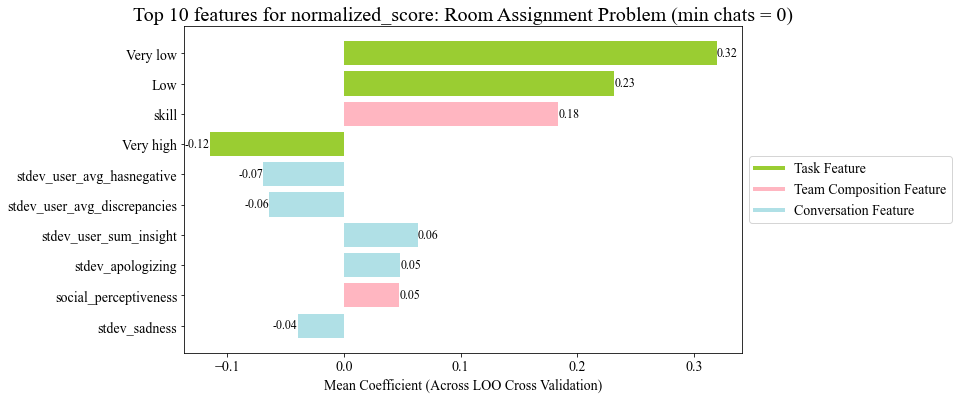

In [762]:
plot_top_n_features(display_feature_coefficients(mlall_feature_coefficients), 10, filepath = "./figures/csop" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats))

Questions:
- More deeply understand difference between LASSO and Ridge
- Better understand `alpha` hyperparameter
- Why doesn't more features mean a better R^2? (Wouldn't the model 'throw out' features that don't work?)

## "Out of Sample" Testing (Using CSOP II)

In [763]:
# Preprocess CSOP 2 to look like CSOP 1
csop2_path = data_path + 'conv/csopII_output_conversation_level.csv'
csop2_conv_data  = pd.read_csv(csop2_path)

csop2_conv_data = csop2_conv_data[csop2_conv_data["sum_num_messages"] >= min_num_chats]

In [764]:
# Test only on the case where the team size = 3
csop2_conv_data = csop2_conv_data[csop2_conv_data["team_size"] == 3]

In [765]:
# First, get the task features
csop2_conv_data["difficulty"] = csop2_conv_data["difficulty"].map({
    "Easy [Corresponds to 'Hard' in PNAS]": "Moderate",
    "Hard [Corresponds to 'Super Hard' in PNAS]": "Very high"
})
task_features_test = csop2_conv_data["difficulty"]


In [766]:
task_features_test = pd.get_dummies(csop2_conv_data["difficulty"])
task_features_test["High"] = 0
task_features_test["Low"] = 0
task_features_test["Very low"] = 0
task_features_test = task_features_test[task_features.columns]

Composition Features
- team_size: Team Size (1-10)
- soc_pers: Social Perceptiveness * (this is the only thing in common with CSOP 1)
- vis_img: Visual Imagery
- int_verb: Internal Verbalization
- ort_img: Orthographic Imagery
- rep_man: Representational Manipulation

The problem is that all these are categorical (e.g., "High", "Mixed", "Low") --- can't be used

In [767]:
team_composition_features_test = csop2_conv_data[["int_verb", "vis_img", "ort_img", "rep_man", "soc_pers", "team_size"]]

In [768]:
def drop_non_common_columns(dfs):
	"""
	Drops any columns that are not shared between dataframes,
	so that they can be plotted on the same axis.

	@param dfs: list of dataframes
	"""

	# Check if there are any data frames in the list
	if not dfs:
		return []

	# Find the intersection of columns in all data frames
	common_columns = set(dfs[0].columns)
	for df in dfs[1:]:
		common_columns = common_columns.intersection(df.columns)

	# Create a new list of data frames with only common columns
	new_data_frames = []
	for df in dfs:
		new_data_frames.append(df[list(common_columns)])

	return new_data_frames

In [769]:
# possible targets to try
targets_test = csop2_conv_data[["efficiency","score","duration"]]
targets_test = pd.DataFrame(StandardScaler().fit_transform(targets_test), columns = targets_test.columns)

# Read in the config file and use that the drop the extraneous columns
with open('./config.json', "rb") as json_file:
    config = json.load(json_file)

conv_features_test = csop2_conv_data.drop(config["csopII"]['cols_to_ignore'], axis = 1)

In [770]:
# Normalization
conv_features_test = pd.DataFrame(StandardScaler().fit_transform(conv_features_test), columns = conv_features_test.columns)
# drop na cols
conv_features_test = conv_features_test.dropna(axis = 1)

In [771]:
# drop cols that aren't in csop I and reorder them the match
_ , conv_features_test = drop_non_common_columns([conv_features, conv_features_test])
conv_features_test = conv_features_test[conv_features.columns]

In [772]:
X_test = pd.concat([task_features_test.reset_index(drop=True), conv_features_test.reset_index(drop=True)], axis=1)

## Pass the desired trained model in from the earlier steps

In [773]:
out_of_sample_test_results = pd.DataFrame(
    {
        "model": [],
        "features_included": [],
        "r2": [],
        "rmse": []
    }
)

models = [model_lasso_task, model_lasso_tconv, model_lasso_comms]
features = ["Task Complexity", "Task Complexity + Communication", "Communication"]
feature_lists = [list(task_features_test.columns), list(task_features_test.columns) + list(conv_features_test.columns), list(conv_features_test.columns)]

for i in range(len(models)):
    model = models[i]
    feature = features[i]
    feature_list = feature_lists[i]

    r2 = r2_score(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)
    rmse = np.sqrt(mean_squared_error(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)).round(4)
    out_of_sample_test_results = pd.concat([out_of_sample_test_results, pd.DataFrame({"model": [model], "features_included": [feature], "r2": [r2], "rmse": [rmse]})], ignore_index=True)

KeyError: 'normalized_score'

In [ ]:
out_of_sample_test_results

,model,features_included,r2,rmse
0,Lasso(alpha=0.0036590762276784935),Task Complexity,-0.0933,1.0456
1,Lasso(alpha=0.15032870211579416),Task Complexity + Communication,0.3260,0.8210
2,Lasso(alpha=0.15032870211579416),Communication,0.3260,0.8210


In [ ]:
directory = os.path.dirname(test_results_output_name)
if not os.path.exists(directory):
    os.makedirs(directory)
out_of_sample_test_results.sort_values(by = "r2", ascending = False).to_csv(test_results_output_name)